In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
S, P = np.load("../data/dataset.npy")
molecules = np.load("../data/molecules.npy")

In [21]:
def extract_triu(A):
    """Extracts the upper triangular part of the matrix.
    Input can be matrix, will be reshaped if it is not.
    """
    return A.reshape(dim, dim)[np.triu_indices(dim)]

def reconstruct_from_triu(A_flat):
    """Reconstructus the full symmetric matrix (dim x dim, not
    flattened out) from the flattend elements of the upper 
    triag of a symmetric matrix!"""
    result = np.zeros((dim, dim))
    result[np.triu_indices(dim)] = A_flat
    return result + result.T - np.diag(np.diag(result))


In [65]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26
dim_triu = int(dim * (dim + 1) / 2)

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_triu = list(map(extract_triu, S))
P_triu = list(map(extract_triu, P))

S_test = np.array(S_triu)[index[150:]]
P_test = np.array(P_triu)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S_triu)[index[:150]]
P_train = np.array(P_triu)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-03-26 14:00:57: Data set normalized. Mean value std: 0.008433127559152844


In [67]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim_triu, 400, 400, dim_triu]),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer.setup()
network, sess = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph = trainer.graph

[-] 2018-03-26 14:01:44: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-26 14:01:44: Setting up the training in the target graph ...
[-] 2018-03-26 14:01:44: network ...
[-] 2018-03-26 14:01:44: error function ...
[-] 2018-03-26 14:01:44: cost function ...
[-] 2018-03-26 14:01:44: training step
[-] 2018-03-26 14:01:44: Starting network training ...
[ ] 2018-03-26 14:01:44: Val. Cost: 9.457E-02. Error: 9.457E-02. Diff: 1.0E+10
[ ] 2018-03-26 14:01:46: Val. Cost: 2.660E-05. Error: 2.445E-05. Diff: 9.5E-02
[ ] 2018-03-26 14:01:47: Val. Cost: 1.546E-05. Error: 1.334E-05. Diff: 1.1E-05
[ ] 2018-03-26 14:01:48: Val. Cost: 1.265E-05. Error: 1.054E-05. Diff: 2.8E-06
[ ] 2018-03-26 14:01:50: Val. Cost: 5.550E-05. Error: 5.339E-05. Diff: 4.3E-05
[ ] 2018-03-26 14:01:51: Val. Cost: 5.390E-05. Error: 5.180E-05. Diff: 1.6E-06
[ ] 2018-03-26 14:01:53: Val. Cost: 2.398E-05. Error: 2.188E-05. Diff: 3.0E-05
[ ] 2018-03-26 14:01:54: Val. Cost: 1.376E-05. Error: 1.166E-05

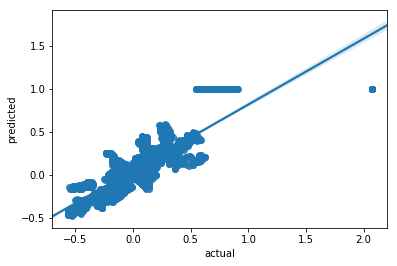

In [68]:
from SCFInitialGuess.utilities.plotutils import prediction_scatter

with graph_orig.as_default():
    prediction_scatter(
        dataset.testing[1].flatten(), 
        network_orig.run(sess_orig, dataset.testing[0]).flatten()
    )
plt.show()

In [69]:
def mc_wheeny_purification(p,s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return (3 * np.dot(np.dot(p, s), p) - np.dot(np.dot(np.dot(np.dot(p, s), p), s), p)) / 2

def multi_mc_wheeny(p, s, n_max=4):
    for i in range(n_max):
        p = mc_wheeny_purification(p, s)
    return p

def idemp_error(p, s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return np.mean(np.abs(np.dot(np.dot(p, s), p) - 2 * p))

In [71]:
for (s, p) in zip(*dataset.testing):
#for (s, p) in zip(S_test, P_test):
    
    #s_norm = s.reshape(1, dim**2)
    s_raw = reconstruct_from_triu(dataset.inverse_input_transform(s))
    p_raw = reconstruct_from_triu(p)
    
    
    print("Orig:         {:0.3E}".format(idemp_error(p_raw, s_raw))) 
    
    with graph.as_default():
        p_nn = reconstruct_from_triu(network.run(sess, s.reshape(1, dim_triu)))
        
    print("NN:           {:0.3E}".format(idemp_error(p_nn, s_raw)))
    print("NN pruified:  {:0.3E}".format(idemp_error(mc_wheeny_purification(p_nn, s_raw), s_raw)))
    p_nn_multi = multi_mc_wheeny(p_nn, s_raw, n_max=5)
    print("NN multified: {:0.3E}".format(idemp_error(p_nn_multi, s_raw))) 
    print("Error NN before: {:0.3E}".format(np.mean(np.abs(p_raw - p_nn))))
    print("Error NN multifed:  {:0.3E}".format(np.mean(np.abs(p_raw - p_nn_multi))))
    print("---------------------------")

Orig:         3.297E-16
NN:           3.531E-03
NN pruified:  1.127E-04
NN multified: 7.431E-17
Error NN before: 2.405E-03
Error NN multifed:  1.602E-03
---------------------------
Orig:         2.585E-16
NN:           5.217E-03
NN pruified:  3.170E-04
NN multified: 7.604E-17
Error NN before: 3.206E-03
Error NN multifed:  1.871E-03
---------------------------
Orig:         3.407E-16
NN:           2.968E-03
NN pruified:  7.994E-05
NN multified: 7.442E-17
Error NN before: 2.276E-03
Error NN multifed:  1.660E-03
---------------------------
Orig:         3.269E-16
NN:           3.242E-03
NN pruified:  1.207E-04
NN multified: 7.141E-17
Error NN before: 2.243E-03
Error NN multifed:  1.469E-03
---------------------------
Orig:         3.619E-16
NN:           3.651E-03
NN pruified:  1.193E-04
NN multified: 7.066E-17
Error NN before: 2.623E-03
Error NN multifed:  1.875E-03
---------------------------
Orig:         2.830E-16
NN:           3.340E-03
NN pruified:  7.430E-05
NN multified: 7.715E-17

In [81]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.plotutils import prediction_scatter

keys = ["noise", "nn", "nn_purified"]

iterations = {}
for k in keys:
    iterations[k] = []

for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    guesses = {}

    s_raw = hf.get_ovlp(mol)
    s_norm = dataset.input_transformation(extract_triu(s_raw)).reshape(1, dim_triu)
    
        
    # P_actual wi noise
    p_raw = reconstruct_from_triu(p)
    p_noise = p_raw + np.random.randn(dim, dim) * 1e-2
    guesses["noise"] = p_noise
    
    
    with graph.as_default():
        p_orig = reconstruct_from_triu(network.run(sess, s_norm)).astype('float64')
        
    guesses["nn"] = p_orig


    p_purified = multi_mc_wheeny(p_orig, s_raw, n_max=5)
    guesses["nn_purified"] = p_purified

    # check errors
    print("Accuracy (MSE):")
    print(" -Noise: {:0.3E}".format(np.mean(np.abs(p_raw - p_noise)**2)))
    print(" -NN:    {:0.3E}".format(np.mean(np.abs(p_raw - p_orig)**2)))
    print(" -Pruif: {:0.3E}".format(np.mean(np.abs(p_raw - p_purified)**2)))

    print("Idempotency:")
    print(" -Noise: {:0.3E}".format(idemp_error(p_noise, s_raw)))
    print(" -Orig:  {:0.3E}".format(idemp_error(p_orig, s_raw)))
    print(" -Purif: {:0.3E}".format(idemp_error(p_purified, s_raw)))

    
    
    for (key, guess) in guesses.items():
        mf = hf.RHF(mol)
        mf.diis = None
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations[key].append(mf.iterations)

for k in keys:
    iterations[k] = np.array(iterations[k])

Warn: Ipython shell catchs sys.args


Calculating: 1/50
Accuracy (MSE):
 -Noise: 1.103E-08
 -NN:    8.762E-06
 -Pruif: 4.197E-06
Idempotency:
 -Noise: 1.190E-04
 -Orig:  3.531E-03
 -Purif: 7.413E-17


Warn: Ipython shell catchs sys.args


Calculating: 2/50
Accuracy (MSE):
 -Noise: 1.047E-08
 -NN:    1.939E-05
 -Pruif: 5.705E-06
Idempotency:
 -Noise: 1.154E-04
 -Orig:  5.217E-03
 -Purif: 7.743E-17


Warn: Ipython shell catchs sys.args


Calculating: 3/50
Accuracy (MSE):
 -Noise: 9.549E-09
 -NN:    8.321E-06
 -Pruif: 4.887E-06
Idempotency:
 -Noise: 1.112E-04
 -Orig:  2.968E-03
 -Purif: 7.236E-17


Warn: Ipython shell catchs sys.args


Calculating: 4/50
Accuracy (MSE):
 -Noise: 1.075E-08
 -NN:    7.725E-06
 -Pruif: 3.613E-06
Idempotency:
 -Noise: 1.165E-04
 -Orig:  3.242E-03
 -Purif: 7.890E-17


Warn: Ipython shell catchs sys.args


Calculating: 5/50
Accuracy (MSE):
 -Noise: 1.012E-08
 -NN:    1.190E-05
 -Pruif: 6.177E-06
Idempotency:
 -Noise: 1.183E-04
 -Orig:  3.651E-03
 -Purif: 7.903E-17


Warn: Ipython shell catchs sys.args


Calculating: 6/50
Accuracy (MSE):
 -Noise: 1.079E-08
 -NN:    8.655E-06
 -Pruif: 4.569E-06
Idempotency:
 -Noise: 1.196E-04
 -Orig:  3.340E-03
 -Purif: 6.910E-17


Warn: Ipython shell catchs sys.args


Calculating: 7/50
Accuracy (MSE):
 -Noise: 9.732E-09
 -NN:    3.754E-06
 -Pruif: 1.675E-06
Idempotency:
 -Noise: 1.103E-04
 -Orig:  2.361E-03
 -Purif: 7.394E-17


Warn: Ipython shell catchs sys.args


Calculating: 8/50
Accuracy (MSE):
 -Noise: 1.012E-08
 -NN:    9.136E-06
 -Pruif: 3.843E-06
Idempotency:
 -Noise: 1.126E-04
 -Orig:  3.425E-03
 -Purif: 7.470E-17


Warn: Ipython shell catchs sys.args


Calculating: 9/50
Accuracy (MSE):
 -Noise: 1.064E-08
 -NN:    1.317E-05
 -Pruif: 6.196E-06
Idempotency:
 -Noise: 1.149E-04
 -Orig:  4.301E-03
 -Purif: 7.118E-17


Warn: Ipython shell catchs sys.args


Calculating: 10/50
Accuracy (MSE):
 -Noise: 1.016E-08
 -NN:    8.939E-06
 -Pruif: 4.089E-06
Idempotency:
 -Noise: 1.175E-04
 -Orig:  3.458E-03
 -Purif: 6.796E-17


Warn: Ipython shell catchs sys.args


Calculating: 11/50
Accuracy (MSE):
 -Noise: 1.050E-08
 -NN:    1.313E-05
 -Pruif: 5.935E-06
Idempotency:
 -Noise: 1.177E-04
 -Orig:  4.264E-03
 -Purif: 7.527E-17


Warn: Ipython shell catchs sys.args


Calculating: 12/50
Accuracy (MSE):
 -Noise: 1.019E-08
 -NN:    6.808E-06
 -Pruif: 3.339E-06
Idempotency:
 -Noise: 1.136E-04
 -Orig:  2.804E-03
 -Purif: 7.273E-17


Warn: Ipython shell catchs sys.args


Calculating: 13/50
Accuracy (MSE):
 -Noise: 1.019E-08
 -NN:    1.952E-05
 -Pruif: 1.010E-05
Idempotency:
 -Noise: 1.151E-04
 -Orig:  5.003E-03
 -Purif: 6.918E-17


Warn: Ipython shell catchs sys.args


Calculating: 14/50
Accuracy (MSE):
 -Noise: 9.268E-09
 -NN:    8.221E-06
 -Pruif: 4.193E-06
Idempotency:
 -Noise: 1.100E-04
 -Orig:  3.152E-03
 -Purif: 8.068E-17


Warn: Ipython shell catchs sys.args


Calculating: 15/50
Accuracy (MSE):
 -Noise: 1.053E-08
 -NN:    8.562E-06
 -Pruif: 4.182E-06
Idempotency:
 -Noise: 1.153E-04
 -Orig:  3.371E-03
 -Purif: 7.327E-17


Warn: Ipython shell catchs sys.args


Calculating: 16/50
Accuracy (MSE):
 -Noise: 9.773E-09
 -NN:    9.483E-06
 -Pruif: 4.176E-06
Idempotency:
 -Noise: 1.144E-04
 -Orig:  3.343E-03
 -Purif: 7.018E-17


Warn: Ipython shell catchs sys.args


Calculating: 17/50
Accuracy (MSE):
 -Noise: 1.013E-08
 -NN:    5.216E-06
 -Pruif: 2.573E-06
Idempotency:
 -Noise: 1.177E-04
 -Orig:  2.383E-03
 -Purif: 7.336E-17


Warn: Ipython shell catchs sys.args


Calculating: 18/50
Accuracy (MSE):
 -Noise: 1.049E-08
 -NN:    1.431E-05
 -Pruif: 4.307E-06
Idempotency:
 -Noise: 1.261E-04
 -Orig:  4.142E-03
 -Purif: 7.135E-17


Warn: Ipython shell catchs sys.args


Calculating: 19/50
Accuracy (MSE):
 -Noise: 1.032E-08
 -NN:    1.117E-04
 -Pruif: 3.190E-05
Idempotency:
 -Noise: 1.231E-04
 -Orig:  8.579E-03
 -Purif: 9.709E-17


Warn: Ipython shell catchs sys.args


Calculating: 20/50
Accuracy (MSE):
 -Noise: 1.049E-08
 -NN:    5.276E-06
 -Pruif: 2.853E-06
Idempotency:
 -Noise: 1.167E-04
 -Orig:  2.465E-03
 -Purif: 6.762E-17


Warn: Ipython shell catchs sys.args


Calculating: 21/50
Accuracy (MSE):
 -Noise: 1.014E-08
 -NN:    1.074E-05
 -Pruif: 4.162E-06
Idempotency:
 -Noise: 1.140E-04
 -Orig:  3.965E-03
 -Purif: 7.638E-17


Warn: Ipython shell catchs sys.args


Calculating: 22/50
Accuracy (MSE):
 -Noise: 9.587E-09
 -NN:    4.025E-06
 -Pruif: 1.780E-06
Idempotency:
 -Noise: 1.132E-04
 -Orig:  2.390E-03
 -Purif: 8.501E-17


Warn: Ipython shell catchs sys.args


Calculating: 23/50
Accuracy (MSE):
 -Noise: 9.728E-09
 -NN:    5.254E-06
 -Pruif: 2.679E-06
Idempotency:
 -Noise: 1.152E-04
 -Orig:  2.519E-03
 -Purif: 7.530E-17


Warn: Ipython shell catchs sys.args


Calculating: 24/50
Accuracy (MSE):
 -Noise: 9.448E-09
 -NN:    1.149E-05
 -Pruif: 3.919E-06
Idempotency:
 -Noise: 1.100E-04
 -Orig:  4.226E-03
 -Purif: 7.544E-17


Warn: Ipython shell catchs sys.args


Calculating: 25/50
Accuracy (MSE):
 -Noise: 9.929E-09
 -NN:    5.451E-06
 -Pruif: 2.514E-06
Idempotency:
 -Noise: 1.067E-04
 -Orig:  2.603E-03
 -Purif: 7.030E-17


Warn: Ipython shell catchs sys.args


Calculating: 26/50
Accuracy (MSE):
 -Noise: 9.970E-09
 -NN:    4.918E-06
 -Pruif: 1.683E-06
Idempotency:
 -Noise: 1.174E-04
 -Orig:  2.633E-03
 -Purif: 7.059E-17


Warn: Ipython shell catchs sys.args


Calculating: 27/50
Accuracy (MSE):
 -Noise: 9.880E-09
 -NN:    8.591E-06
 -Pruif: 3.631E-06
Idempotency:
 -Noise: 1.074E-04
 -Orig:  3.420E-03
 -Purif: 6.272E-17


Warn: Ipython shell catchs sys.args


Calculating: 28/50
Accuracy (MSE):
 -Noise: 9.153E-09
 -NN:    8.384E-06
 -Pruif: 3.445E-06
Idempotency:
 -Noise: 1.126E-04
 -Orig:  3.491E-03
 -Purif: 7.017E-17


Warn: Ipython shell catchs sys.args


Calculating: 29/50
Accuracy (MSE):
 -Noise: 9.568E-09
 -NN:    7.391E-06
 -Pruif: 3.019E-06
Idempotency:
 -Noise: 1.161E-04
 -Orig:  2.969E-03
 -Purif: 7.390E-17


Warn: Ipython shell catchs sys.args


Calculating: 30/50
Accuracy (MSE):
 -Noise: 1.026E-08
 -NN:    1.467E-05
 -Pruif: 6.261E-06
Idempotency:
 -Noise: 1.185E-04
 -Orig:  4.404E-03
 -Purif: 7.538E-17


Warn: Ipython shell catchs sys.args


Calculating: 31/50
Accuracy (MSE):
 -Noise: 1.017E-08
 -NN:    1.100E-05
 -Pruif: 5.767E-06
Idempotency:
 -Noise: 1.232E-04
 -Orig:  3.937E-03
 -Purif: 7.088E-17


Warn: Ipython shell catchs sys.args


Calculating: 32/50
Accuracy (MSE):
 -Noise: 1.012E-08
 -NN:    4.748E-06
 -Pruif: 1.792E-06
Idempotency:
 -Noise: 1.238E-04
 -Orig:  2.419E-03
 -Purif: 6.705E-17


Warn: Ipython shell catchs sys.args


Calculating: 33/50
Accuracy (MSE):
 -Noise: 9.185E-09
 -NN:    4.986E-06
 -Pruif: 2.026E-06
Idempotency:
 -Noise: 1.065E-04
 -Orig:  2.715E-03
 -Purif: 8.233E-17


Warn: Ipython shell catchs sys.args


Calculating: 34/50
Accuracy (MSE):
 -Noise: 9.380E-09
 -NN:    4.003E-06
 -Pruif: 1.774E-06
Idempotency:
 -Noise: 1.143E-04
 -Orig:  2.367E-03
 -Purif: 7.152E-17


Warn: Ipython shell catchs sys.args


Calculating: 35/50
Accuracy (MSE):
 -Noise: 1.026E-08
 -NN:    1.156E-05
 -Pruif: 4.818E-06
Idempotency:
 -Noise: 1.176E-04
 -Orig:  4.032E-03
 -Purif: 7.652E-17


Warn: Ipython shell catchs sys.args


Calculating: 36/50
Accuracy (MSE):
 -Noise: 9.615E-09
 -NN:    7.085E-06
 -Pruif: 4.131E-06
Idempotency:
 -Noise: 1.132E-04
 -Orig:  2.737E-03
 -Purif: 7.118E-17


Warn: Ipython shell catchs sys.args


Calculating: 37/50
Accuracy (MSE):
 -Noise: 9.203E-09
 -NN:    8.633E-06
 -Pruif: 4.978E-06
Idempotency:
 -Noise: 1.147E-04
 -Orig:  3.034E-03
 -Purif: 7.710E-17


Warn: Ipython shell catchs sys.args


Calculating: 38/50
Accuracy (MSE):
 -Noise: 9.071E-09
 -NN:    2.866E-05
 -Pruif: 1.257E-05
Idempotency:
 -Noise: 1.150E-04
 -Orig:  5.513E-03
 -Purif: 7.624E-17


Warn: Ipython shell catchs sys.args


Calculating: 39/50
Accuracy (MSE):
 -Noise: 1.049E-08
 -NN:    1.147E-05
 -Pruif: 5.375E-06
Idempotency:
 -Noise: 1.236E-04
 -Orig:  3.635E-03
 -Purif: 6.590E-17


Warn: Ipython shell catchs sys.args


Calculating: 40/50
Accuracy (MSE):
 -Noise: 1.001E-08
 -NN:    3.641E-06
 -Pruif: 1.619E-06
Idempotency:
 -Noise: 1.223E-04
 -Orig:  2.322E-03
 -Purif: 7.488E-17


Warn: Ipython shell catchs sys.args


Calculating: 41/50
Accuracy (MSE):
 -Noise: 9.907E-09
 -NN:    1.155E-05
 -Pruif: 6.415E-06
Idempotency:
 -Noise: 1.194E-04
 -Orig:  4.006E-03
 -Purif: 7.633E-17


Warn: Ipython shell catchs sys.args


Calculating: 42/50
Accuracy (MSE):
 -Noise: 9.899E-09
 -NN:    6.274E-06
 -Pruif: 3.179E-06
Idempotency:
 -Noise: 1.198E-04
 -Orig:  2.818E-03
 -Purif: 7.095E-17


Warn: Ipython shell catchs sys.args


Calculating: 43/50
Accuracy (MSE):
 -Noise: 8.928E-09
 -NN:    7.422E-06
 -Pruif: 3.309E-06
Idempotency:
 -Noise: 1.132E-04
 -Orig:  3.098E-03
 -Purif: 7.314E-17


Warn: Ipython shell catchs sys.args


Calculating: 44/50
Accuracy (MSE):
 -Noise: 1.018E-08
 -NN:    5.133E-06
 -Pruif: 1.962E-06
Idempotency:
 -Noise: 1.181E-04
 -Orig:  2.539E-03
 -Purif: 7.910E-17


Warn: Ipython shell catchs sys.args


Calculating: 45/50
Accuracy (MSE):
 -Noise: 9.733E-09
 -NN:    2.008E-05
 -Pruif: 5.451E-06
Idempotency:
 -Noise: 1.105E-04
 -Orig:  4.109E-03
 -Purif: 7.777E-17


Warn: Ipython shell catchs sys.args


Calculating: 46/50
Accuracy (MSE):
 -Noise: 9.899E-09
 -NN:    1.161E-05
 -Pruif: 4.593E-06
Idempotency:
 -Noise: 1.236E-04
 -Orig:  3.931E-03
 -Purif: 6.419E-17


Warn: Ipython shell catchs sys.args


Calculating: 47/50
Accuracy (MSE):
 -Noise: 9.580E-09
 -NN:    8.754E-06
 -Pruif: 4.671E-06
Idempotency:
 -Noise: 1.126E-04
 -Orig:  3.474E-03
 -Purif: 8.429E-17


Warn: Ipython shell catchs sys.args


Calculating: 48/50
Accuracy (MSE):
 -Noise: 9.834E-09
 -NN:    7.348E-06
 -Pruif: 3.248E-06
Idempotency:
 -Noise: 1.130E-04
 -Orig:  3.266E-03
 -Purif: 7.279E-17


Warn: Ipython shell catchs sys.args


Calculating: 49/50
Accuracy (MSE):
 -Noise: 8.910E-09
 -NN:    8.236E-06
 -Pruif: 3.804E-06
Idempotency:
 -Noise: 1.112E-04
 -Orig:  2.927E-03
 -Purif: 7.249E-17


Warn: Ipython shell catchs sys.args


Calculating: 50/50
Accuracy (MSE):
 -Noise: 1.009E-08
 -NN:    8.153E-06
 -Pruif: 3.143E-06
Idempotency:
 -Noise: 1.247E-04
 -Orig:  3.354E-03
 -Purif: 7.326E-17


In [83]:
for key, val in iterations.items():
    print(key + ": " + str(val.mean()))

noise: 5.74
nn: 13.12
nn_purified: 9.12


In [94]:
from SCFInitialGuess.utilities.plotutils import iterations_histogram
from pandas import  DataFrame
import seaborn as sns

data = DataFrame(iterations)
for key, val in iterations.items():
    hist, bins = np.histogram(val)
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()
plt.show()

TypeError: Argument 'obj' has incorrect type (expected list, got dict_values)